# Board Game Recommender - Data Cleaning

This notebook walks through the process of preparing the data gathered in bgg-data-scrape for use in the recommender system.

The first step is to import the necessary packages as well as the data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
# Read the saved BGG database
game_df = pd.read_json('bgg_database.json')

In [3]:
game_df.index.name = 'gameid'
game_df = game_df.reset_index().sort_values('rank')
game_df.head()

,gameid,attributes,average_rating,description,families,last_updated,name,num_voters,play_time,player_count,rank,ratings,weight,weighted_rating,year
1691,174430,"{u'boardgamedesigner': u'Isaac Childres', u'bo...",8.91228,Gloomhaven is a game of Euro-inspired tactica...,"[thematic, strategygames]",Mon Mar 18 23:34:48 2019,Gloomhaven,23504,120,"{u'1': {u'Recommended': u'267', u'Not Recommen...",1,"{u'pinbot': u'9', u'ladenedge': u'10', u'thesp...",3.7753,8.61315,2017
1344,161936,"{u'boardgamedesigner': u'Matt Leacock', u'boar...",8.64675,Pandemic Legacy is a co-operative campaign gam...,"[thematic, strategygames]",Mon Mar 18 22:47:26 2019,Pandemic Legacy: Season 1,30370,60,"{u'1': {u'Recommended': u'63', u'Not Recommend...",2,"{u'jocar84': u'9.5', u'horgboth': u'9', u'DerS...",2.8318,8.49226,2015
1903,182028,"{u'boardgamedesigner': u'Vlaada Chvátil', u'bo...",8.54243,Through the Ages: A New Story of Civilization ...,[strategygames],Tue Mar 19 00:58:33 2019,Through the Ages: A New Story of Civilization,15179,120,"{u'1': {u'Recommended': u'5', u'Not Recommende...",3,"{u'the_ka': u'8', u'jmwillis5': u'9.37', u'Doe...",4.3657,8.26341,2015
1489,167791,"{u'boardgamedesigner': u'Jacob Fryxelius', u'b...",8.40232,"In the 2400s, mankind begins to terraform the ...",[strategygames],Mon Mar 18 21:30:17 2019,Terraforming Mars,36736,120,"{u'1': {u'Recommended': u'434', u'Not Recommen...",4,"{u'AkeTharus': u'10', u'jocar84': u'9', u'andi...",3.2313,8.23708,2016
377,12333,"{u'boardgamedesigner': u'Jason Matthews', u'bo...",8.32508,"&quot;Now the trumpet summons us again, not as...","[wargames, strategygames]",Mon Mar 18 22:47:26 2019,Twilight Struggle,33857,180,"{u'1': {u'Recommended': u'22', u'Not Recommend...",5,"{u'wooda': u'8', u'andi1977': u'10', u'Elirirz...",3.5645,8.17631,2005


To make the data easy to save and handle, the dictionaries of ratings for each game are extracted from the "ratings" column of the data frame and organized into a long-format data frame.

In [4]:
# Create a dataframe of only the user, game ID, and score for each game
ratings = []
for i, row in game_df.iterrows():
    for user, score in row.ratings.iteritems():
        rating = (row['gameid'], user, float(score))
        ratings.append(rating)
ratings = pd.DataFrame(ratings, columns = ['gameid', 'user', 'score'])

In [5]:
ratings.head()

,gameid,user,score
0,174430,pinbot,9.0
1,174430,ladenedge,10.0
2,174430,thesponsduke,9.0
3,174430,capman2000,8.0
4,174430,Jedirikk,9.0


In [6]:
ratings.shape

(11310912, 3)

There are over 11 million ratings contained in this data frame.  However, many users may have very few ratings (perhaps only 1 rating).  These users will not be useful for collaborative filtering, so those data points should be removed.  To sort those out, a histogram of the distribution of number of ratings each user has given will be useful.  The histogram plotted below shows that around 20000 users have rated fewer than 50 games.

In [7]:
# Find the distribution of number of ratings each user has given
user_rating_counts = ratings.groupby('user').size().reset_index()
user_rating_counts.columns = ['user', 'num_ratings']
user_rating_counts = user_rating_counts.sort_values('num_ratings', ascending=False)
print str(len(user_rating_counts)) + ' users have rated at least 1 game.'
user_rating_counts.head()

272553 users have rated at least 1 game.


,user,num_ratings
205016,leffe dubbel,4585
31171,Doel,2662
126858,Walt Mulder,2510
120761,TomVasel,2457
50126,Hessu68,2366


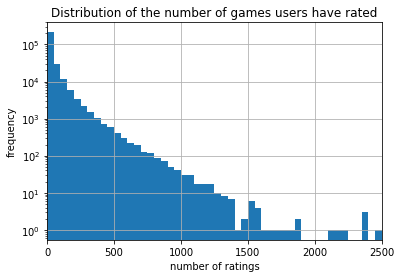

In [20]:
# Visualize above distribution
user_rating_counts.hist(column = 'num_ratings', bins = range(0,2550,50))
plt.title('Distribution of the number of games users have rated')
plt.yscale('log')
plt.ylabel('frequency')
plt.xlabel('number of ratings')
plt.xlim(0, 2500)
plt.show()

The same should be done for games.  However, even the least rated game in the database has 100 ratings.  This is because BoardGameGeek.com does not rank games until they have at least 100 ratings.

In [9]:
item_rating_counts = ratings.groupby('gameid').size().reset_index()
item_rating_counts.columns = ['gameid', 'num_ratings']
item_rating_counts = item_rating_counts.sort_values('num_ratings', ascending=False)
item_rating_counts.head()

,gameid,num_ratings
10,13,83852
345,822,83545
1712,30549,81719
2297,68448,67758
1855,36218,67366


In [10]:
item_rating_counts.num_ratings.min()

100

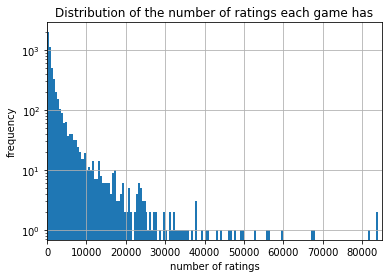

In [11]:
item_rating_counts.hist(column = 'num_ratings', bins = range(0,85500,500))
plt.title('Distribution of the number of ratings each game has')
plt.yscale('log')
plt.ylabel('frequency')
plt.xlabel('number of ratings')
plt.xlim(0, 85000)
plt.show()

Now the data can be trimmed.  The function trim_mins_to is defined to trim data to specified minimum values.  Because removing data based on user count affects item count (and *vice versa*), the removals are performed iteratively, alternating between the 2 criteria, until no more removals are performed.

In [12]:
def trim_mins_to(ratings, user_min=0, item_min=0):
    """This function removes data points from the rating matrix corresponding
    to users and items with fewer than a defined number of ratings."""
    min_check = False
    
    while min_check == False:
        # make table of user rating counts
        user_rating_counts = ratings.groupby('user').size().reset_index()
        user_rating_counts.columns = ['user', 'num_ratings']
        
        # trim users with fewer ratings than user_min
        high_n_users = user_rating_counts[user_rating_counts.num_ratings >= user_min]
        ratings = ratings[ratings['user'].isin(high_n_users['user'])]
        
        # make table of item rating counts
        item_rating_counts = ratings.groupby('gameid').size().reset_index()
        item_rating_counts.columns = ['gameid', 'num_ratings']
        
        # check if items need to be trimmed after trimming users
        if item_rating_counts.num_ratings.min() >= item_min:
            min_check = True
        else:
            # trim items with fewer ratings than item_min
            high_n_items = item_rating_counts[item_rating_counts.num_ratings >= item_min]
            ratings = ratings[ratings['gameid'].isin(high_n_items['gameid'])]
            
    return ratings

Now the data are trimmed until there are at least 50 ratings for each game, and each user has rated at least 50 games.  This number is defined somewhat arbitrarily.

In [13]:
# trim users and items with under 50 ratings
ratings = trim_mins_to(ratings, 50, 50)

In [14]:
# show how many users and games remain after trimming
n_users = len(ratings.user.unique())
n_games = len(ratings.gameid.unique())
print str(n_users) + ' users'
print str(n_games) + ' games'

59032 users
5076 games


In [16]:
# save trimmed ratings
ratings.to_json('ratings_reduced.json')

The first method for collaborative filtering (see collaborative-filtering-memory notebook) will be using user similarity based on cosine similarity.  The computational cost of this method scales as the square of the number of users, so the number of users should be trimmed down further for testing this model

In [17]:
# trim users with under 300 ratings and items with under 50 ratings
ratings = trim_mins_to(ratings, 300, 50)

In [18]:
# show how many users and games remain after trimming
n_users = len(ratings.user.unique())
n_games = len(ratings.gameid.unique())
print str(n_users) + ' users'
print str(n_games) + ' games'

5585 users
4535 games


In [19]:
# save trimmed ratings
ratings.to_json('ratings_vreduced.json')